In [76]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold, LeaveOneOut
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.decomposition import PCA
import umap
import json
import cupy
from tqdm import tqdm
from gtfparse import read_gtf

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm

from sklearn import svm
from xgboost import XGBRegressor
from scipy.stats import spearmanr

from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import mean_absolute_error as MAE


In [167]:
transcripts = {
    "HEART": {
        "male": [],
        "female": []
    }, 
    "BRAIN0": {
        "male": [],
        "female": []
    }, 
    "BRAIN1": {
        "male": [],
        "female": []
    }, 
}

In [278]:
fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'
# model_type = 'knn'

feature_importance_method = 'native'
feature_importance_method = 'SHAP'

n_features = 0

# value_to_predict = 'population'
value_to_predict = 'Age'

organ = "HEART"
organ = "BRAIN0"
organ = "BRAIN1"
# 
sex = 'male'
sex = 'female'

n_opt_features = {
    "HEART": {
        "male": 9,
        "female": 11
    }, 
    "BRAIN0": {
        "male": 7,
        "female": 7
    }, 
    "BRAIN1": {
        "male": 17,
        "female": 8
    }, 
}

# transcripts[organ] = {}
# transcripts[organ][sex] = []


In [279]:
fdir_processed / f'{organ}.preprocessed.h5'

PosixPath('../data/interim/BRAIN1.preprocessed.h5')

In [280]:
# gtf_rawdata = read_gtf(fdir_raw / 'all_transcripts_strigtie_merged.gtf')
# gtf_data = gtf_rawdata.to_pandas()
# gtf_data = gtf_data.set_index('transcript_id')
# gtf_data['transcript_id'] = gtf_data.index

# gtf_data

In [281]:
data = pd.read_hdf(fdir_processed / f'{organ}.preprocessed.h5', key="data")
data_header = pd.read_hdf(fdir_processed / f'{organ}.preprocessed.h5', key="header")

data = data.iloc[:, np.argwhere(np.sum(data > 0, axis=0) > 18).ravel()]
# data
if organ == "BRAIN1":
    data_header['sex'] = data_header['gender'] 

data_male = data.loc[data_header['sex'] == "male"]
data_female = data.loc[data_header['sex'] == "female"]

data_header_male = data_header.loc[data_header['sex'] == "male"]
data_header_female = data_header.loc[data_header['sex'] == "female"]

# fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
# sns.regplot(y=data[data.columns[0]], x=data_header['Age'], ax=axs[0], label='male+female')
# sns.regplot(y=data[data.columns[0]].loc[data_header['sex'] == 'male'], x=data_header['Age'].loc[data_header['sex'] == 'male'], ax=axs[1], 
#             label='male')
# sns.regplot(y=data[data.columns[0]].loc[data_header['sex'] == 'female'], x=data_header['Age'].loc[data_header['sex'] == 'female'], ax=axs[1], 
#             label='female')
# axs[0].legend()
# axs[1].legend()


data = data.loc[data_header['sex'] == sex]
data_header = data_header.loc[data_header['sex'] == sex]



In [282]:
rhos_male = []
pvalues_male = []
rhos_female = []
pvalues_female = []

for i in tqdm(range(data_male.values.shape[1])):
    # rho, pvalue = spearmanr(X[:, i], y)
    rho, pvalue = spearmanr(data_male.values[:, i], data_header_male['Age'].values)
    rhos_male.append(rho)
    pvalues_male.append(pvalue)
    
for i in tqdm(range(data_female.values.shape[1])):
    rho, pvalue = spearmanr(data_female.values[:, i], data_header_female['Age'].values)
    rhos_female.append(rho)
    pvalues_female.append(pvalue)
# rho, pvalue = spearmanr(X, y.values.reshape(1,-1), axis=1)
rhos_male = np.array(rhos_male)
rhos_female = np.array(rhos_female)

  0%|          | 0/17915 [00:00<?, ?it/s]/tmp/ipykernel_59675/2184972271.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pvalue = spearmanr(data_female.values[:, i], data_header_female['Age'].values)
100%|██████████| 17915/17915 [00:11<00:00, 1577.38it/s]


nan
0.35044502168047953
nan


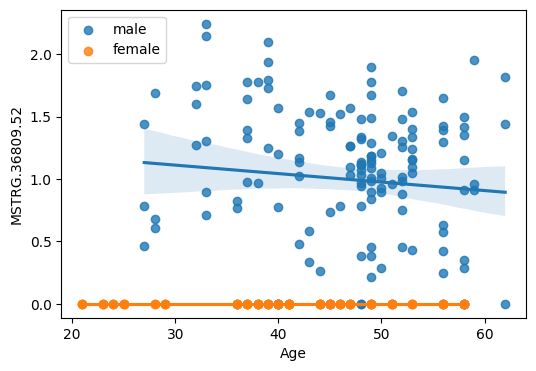

In [283]:
# rhos_male_sign = rhos_male > 0
# rhos_female_sign = rhos_female > 0

# diff_corr_ids = np.where(np.logical_xor(rhos_male_sign, rhos_female_sign))
# diff_corr_ids_sorted = np.argsort(np.abs(rhos_female[diff_corr_ids]))[::-1]

diff_corr_ids_sorted = np.argsort((rhos_male - rhos_female)**2)[::-1]


index = 2
print((rhos_male - rhos_female)[diff_corr_ids_sorted[index]])

print(pvalues_male[diff_corr_ids_sorted[index]])
print(pvalues_female[diff_corr_ids_sorted[index]])


fig, axs = plt.subplots(figsize=(6, 4))
# sns.regplot(y=data[data.columns[sorted_corr_ids[0]]], x=data_header['Age'], ax=axs[0], label='male+female')
sns.regplot(y=data_male[data_male.columns[diff_corr_ids_sorted[index]]], x=data_header_male['Age'], ax=axs, label='male')
sns.regplot(y=data_female[data_female.columns[diff_corr_ids_sorted[index]]], x=data_header_female['Age'], ax=axs, label='female')
axs.legend()


In [284]:
# eval_organ = "BRAIN0"
# eval_organ = "BRAIN1"
# eval_organ = 'HEART'
eval_organ = organ

fname = next((fdir_external / eval_organ / 'reg').glob("*processed.h5"))
fname = fname.name
data_eval = pd.read_hdf(fdir_external / eval_organ / 'reg' / fname, index_col=0)
data_eval_header = pd.read_csv(fdir_external / eval_organ / 'reg' / 'SraRunTable.txt', sep=',')
data_eval_header.set_index("Run", inplace=True)

if eval_organ == "BRAIN1":
    data_eval_header['sex'] = data_eval_header['gender'] 

data_eval_header = data_eval_header.loc[data_eval_header['sex'] == sex]
data_eval = data_eval.loc[(data_eval_header['sex'] == sex).index]


In [285]:
common_transcripts = data.columns.intersection(data_eval.columns)

data_eval = data_eval[common_transcripts]
data = data[common_transcripts]
data

,ENST00000003912.7,ENST00000004103.8,ENST00000005340.10,ENST00000006658.11,ENST00000011473.6,ENST00000012134.7,ENST00000019019.6,ENST00000040877.2,ENST00000043402.8,ENST00000070846.11,...,MSTRG.9920.54,MSTRG.9929.23,MSTRG.9929.7,MSTRG.993.1,MSTRG.9947.1,MSTRG.9948.7,MSTRG.9968.1,MSTRG.9975.19,MSTRG.9996.5,MSTRG.9996.8
SRR19147434,0.035113,0.000000,0.000000,0.000000,2.541312,1.165357,0.000000,0.000000,0.000000,1.324862,...,0.439607,0.412652,0.962864,0.161302,0.481970,0.112381,0.045710,2.256034,1.917703,0.000000
SRR19147442,0.000000,0.794052,0.639125,2.711348,1.775380,0.000000,0.064382,0.000000,0.050570,0.000000,...,0.402106,0.149464,0.113675,1.355619,0.250905,0.377805,0.050970,0.017744,2.300946,0.799852
SRR19147446,0.074349,0.753136,0.708915,0.000000,1.378070,2.801095,0.000000,0.000000,0.000000,0.493102,...,0.248560,0.000000,0.862037,1.057980,0.000000,0.358265,0.618596,0.000000,1.235949,0.619376
SRR19147447,0.090973,0.000000,0.477256,0.000000,2.109113,0.577190,0.000000,0.404090,0.060731,1.621448,...,0.361008,0.000000,0.109881,0.000000,0.791788,1.235325,1.264548,1.040307,0.000000,0.000000
SRR19147449,3.216066,0.000000,0.231375,2.159864,1.795123,2.483123,0.205097,0.644347,0.000000,1.492418,...,0.000000,0.617182,0.000000,0.000000,0.301595,1.491003,0.203924,0.000000,1.878485,0.302905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR19147639,0.018694,1.439938,0.000000,0.871802,0.812680,1.920269,1.853739,0.373347,1.485324,0.352790,...,0.682039,0.105977,0.048169,0.440572,0.138066,1.424093,0.904682,0.000000,1.860002,0.379787
SRR19147640,0.067368,0.853492,0.959471,0.000000,2.188290,0.368054,0.105354,0.923482,1.733386,0.000000,...,0.000000,0.172310,0.131330,0.000000,0.000000,0.000000,0.118245,0.000000,0.000000,0.000000
SRR19147643,0.053578,0.871527,0.000000,1.673051,0.000000,0.000000,0.029692,0.000000,0.000000,0.051819,...,0.000000,0.000000,0.000000,0.990722,0.193961,1.102999,0.155117,0.000000,3.188317,0.601204
SRR19147645,0.018633,0.229080,0.795503,0.975072,3.027320,0.000000,0.279622,0.413792,1.840818,0.045711,...,0.000000,0.000000,0.123792,0.000000,0.742506,0.167535,0.050493,0.000000,1.644255,0.110735


In [286]:
# y = data_header[value_to_predict]
# X = data.values

y = data_header.loc[data_header['sex'] == sex][value_to_predict]
X = data.loc[data_header['sex'] == sex].values
y

SRR19147434    41
SRR19147442    47
SRR19147446    38
SRR19147447    39
SRR19147449    53
               ..
SRR19147639    24
SRR19147640    40
SRR19147643    56
SRR19147645    23
SRR19147647    25
Name: Age, Length: 65, dtype: int64

In [287]:


rhos = []
pvalues = []

for i in tqdm(range(X.shape[1])):
    # rho, pvalue = spearmanr(X[:, i], y)
    rho, pvalue = spearmanr(X[:, i], y)
    rhos.append(rho)
    pvalues.append(pvalue)
# rho, pvalue = spearmanr(X, y.values.reshape(1,-1), axis=1)


  0%|          | 0/17915 [00:00<?, ?it/s]/tmp/ipykernel_59675/2488520612.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pvalue = spearmanr(X[:, i], y)
100%|██████████| 17915/17915 [00:11<00:00, 1605.21it/s]


In [288]:
# np.argwhere(np.array(pvalues) < 0.05).shape
unsignificant_corr_ids = np.argwhere(np.array(pvalues) > 0.05)
# unsignificant_corr_ids

rhos = np.array(rhos)
rhos[unsignificant_corr_ids] = 0
rhos[np.argwhere(X.mean(axis=0) == 0)] = 0


In [289]:
corr_threshold = 0.96
corr_threshold = 0.5
corr_threshold = 0.1

if np.abs(rhos).max() > corr_threshold:
    sorted_corr_border = np.argwhere(np.sort(np.abs(rhos))[::-1] > corr_threshold).max()
    sorted_corr_ids = np.argsort(np.abs(rhos))[::-1][:sorted_corr_border]
    # np.sort(np.abs(rhos))[::-1][:sorted_corr_border], sorted_corr_ids
else:
    sorted_corr_ids = []

In [290]:
# model = XGBRegressor(n_estimators=300, max_depth=4, )

# X = data.values
# y = data_header['Age'].loc[data_header['sex'] == sex].values

# # model.fit(RobustScaler().fit_transform(X),  y)
# model.fit(X,  y)
# importances = model.feature_importances_

# sorted_corr_ids = np.argsort(importances).ravel()[::-1][:50]

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

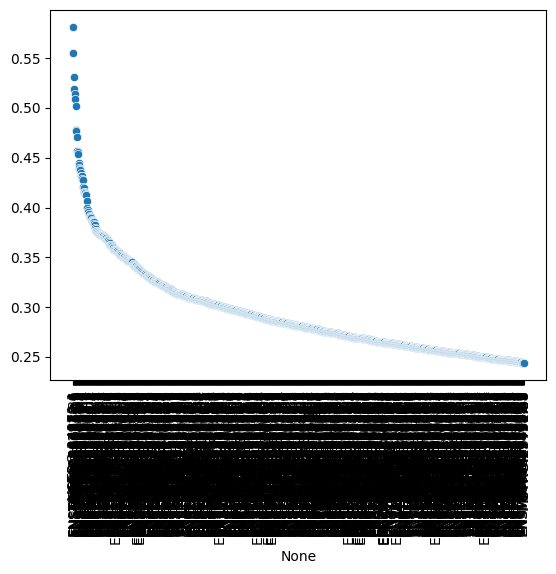

In [291]:
# plt.figure(figsize=(16,6))
sns.scatterplot(
    y=np.abs(rhos[sorted_corr_ids]), 
    x=data.columns[sorted_corr_ids],
    )
plt.xticks(rotation=90)

In [292]:
data.columns[sorted_corr_ids], len(sorted_corr_ids) 

(Index(['MSTRG.24372.1', 'ENST00000562938.6', 'MSTRG.30797.34',
        'ENST00000636170.1', 'ENST00000368732.5', 'ENST00000414562.1',
        'MSTRG.29364.2', 'MSTRG.27407.13', 'MSTRG.21565.34',
        'ENST00000390517.1',
        ...
        'MSTRG.15201.6', 'ENST00000641834.2', 'MSTRG.35493.2', 'MSTRG.31745.5',
        'MSTRG.3370.10', 'MSTRG.14239.13', 'ENST00000654988.1',
        'ENST00000476562.5', 'MSTRG.29498.18', 'MSTRG.28762.46'],
       dtype='object', length=1034),
 1034)

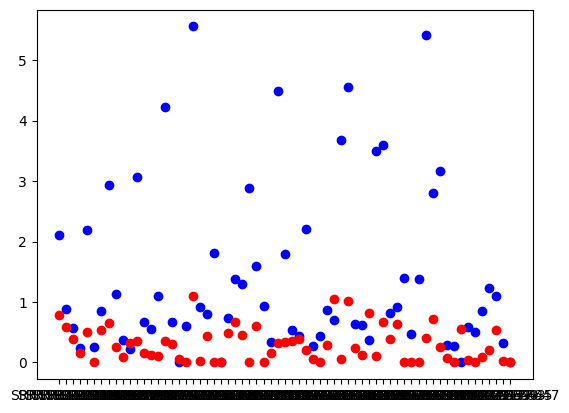

In [293]:
plt.plot(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][0]], 'bo')
plt.plot(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][1]], 'ro')

In [294]:
data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][0]]

SRR19147434    2.106808
SRR19147442    0.878456
SRR19147446    0.566716
SRR19147447    0.243563
SRR19147449    2.192655
                 ...   
SRR19147639    0.856650
SRR19147640    1.235301
SRR19147643    1.103090
SRR19147645    0.324511
SRR19147647    0.000000
Name: MSTRG.24372.1, Length: 65, dtype: float32

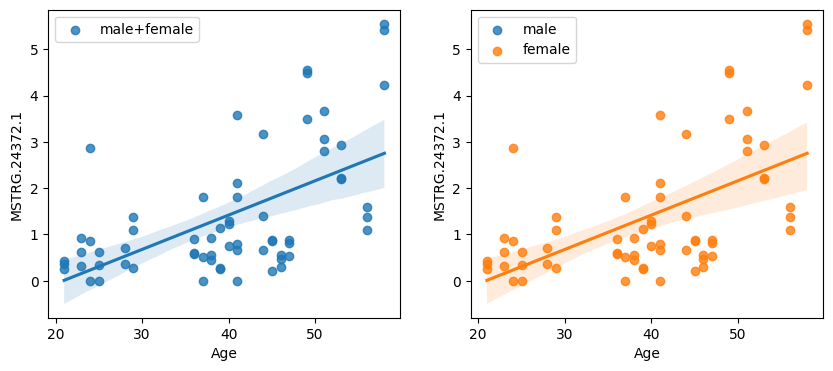

In [295]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]], x=data_header['Age'], ax=axs[0], label='male+female')
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]].loc[data_header['sex'] == 'male'], x=data_header['Age'].loc[data_header['sex'] == 'male'], ax=axs[1], 
            label='male')
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]].loc[data_header['sex'] == 'female'], x=data_header['Age'].loc[data_header['sex'] == 'female'], ax=axs[1], 
            label='female')
axs[0].legend()
axs[1].legend()

In [296]:


# n_features = 5
# n_features = -1

# sex = 'male'

print(data.shape[0])

for n_features in range(1, np.min([data.shape[0]+1, len(sorted_corr_ids)+1, 20])):
# for n_features in [5]:

    X = data[data.columns[sorted_corr_ids[:n_features]]].values
    y = data_header['Age'].loc[data_header['sex'] == sex].values

    # print(X.shape)
    print(f"{n_features=}")
    
    # cv = StratifiedKFold(n_splits=5)
    cv = LeaveOneOut()

    preds = []
    vals  = []
    gls_preds = []
    
    rmses = []
    r2s = []

    for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
        X_train = X[train]
        y_train = y[train]
        X_test = X[val]
        y_test = y[val]

        # train_scaler = RobustScaler().fit(X_train)
        # test_scaler = RobustScaler().fit(X_test)
        # X_train = train_scaler.transform(X_train)
        # X_test = test_scaler.transform(X_test)

        X_train_ = X_train
        y_train_ = y_train
        
        X_val = X_test
        y_val = y_test
        
        # X_val = data_eval[data_eval.columns[sorted_corr_ids[:n_features]]].values
        # y_val = data_eval_header['Age'].loc[data_eval_header['sex']==sex].values


        model = svm.SVR(kernel='linear')
        # model = svm.LinearSVR(loss='squared_epsilon_insensitive')
        # model = LinearRegression()
        # model = Ridge()
        # model = XGBRegressor(n_estimators=300, max_depth=4, )
        # model = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
        #                      param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 20)})    
        
        model.fit(X_train_, y_train_)
        pred = model.predict(X_val)

        preds.append(pred)
        vals.append(y_val)
                
        # X_train_ = sm.add_constant(X_train_)
        # X_test = sm.add_constant(X_test, has_constant='add')
        
        # mod = sm.GLS(y_train_, X_train_).fit()
        # gls_pred = mod.predict(X_test)
        # gls_preds.append(gls_pred)
        
        # rmses.append(
        #     RMSE(pred, y_val)
        # )
        # r2s.append(
        #     r2_score(y_val, pred)
        # )

    print("RMSE: ", RMSE(preds, vals))
    # print("RMSE: ", RMSE(gls_preds, vals))
    print("R2: ", r2_score(vals, preds))
    # print("R2: ", r2_score(vals, gls_preds))
    
    # print("RMSE: ", np.mean(rmses))
    # print("R2: ", np.mean(r2s))
    
    # print(data.columns[sorted_corr_ids[:n_features]])
    print("-"*20)
    # print(model.coef_)
    # print(model.intercept_)

    # plt.plot(vals, "bo")
    # plt.plot(preds, "ro")
    # plt.show()

model.coef_

65
n_features=1


65it [00:00, 1883.93it/s]


RMSE:  8.885525335594119
R2:  0.3034421932634339
--------------------
n_features=2


65it [00:00, 1927.03it/s]


RMSE:  8.788889956932175
R2:  0.3185107671863219
--------------------
n_features=3


65it [00:00, 2160.40it/s]


RMSE:  8.473955308668767
R2:  0.3664756917616605
--------------------
n_features=4


65it [00:00, 2241.58it/s]


RMSE:  7.893622899619121
R2:  0.4502772693439441
--------------------
n_features=5


65it [00:00, 2097.04it/s]


RMSE:  7.8819089477799045
R2:  0.45190761011272396
--------------------
n_features=6


65it [00:00, 1966.81it/s]


RMSE:  7.482492380858472
R2:  0.5060494066067751
--------------------
n_features=7


65it [00:00, 1747.59it/s]


RMSE:  7.08911596357727
R2:  0.5566210137237785
--------------------
n_features=8


65it [00:00, 1780.67it/s]


RMSE:  7.347425329455806
R2:  0.5237211381394495
--------------------
n_features=9


65it [00:00, 1802.48it/s]


RMSE:  7.136157874323937
R2:  0.5507171471512474
--------------------
n_features=10


65it [00:00, 1523.14it/s]


RMSE:  7.106557831649429
R2:  0.5544365745649495
--------------------
n_features=11


65it [00:00, 1782.65it/s]


RMSE:  7.243650082319062
R2:  0.537080078877786
--------------------
n_features=12


65it [00:00, 1804.57it/s]


RMSE:  7.455910420698176
R2:  0.5095527451998692
--------------------
n_features=13


65it [00:00, 1752.91it/s]


RMSE:  7.777908509003651
R2:  0.46627615575189985
--------------------
n_features=14


65it [00:00, 1581.00it/s]


RMSE:  7.248023753082014
R2:  0.5365208937874175
--------------------
n_features=15


65it [00:00, 1620.80it/s]


RMSE:  7.174683158569154
R2:  0.545853053207958
--------------------
n_features=16


65it [00:00, 1664.93it/s]


RMSE:  6.911932160480887
R2:  0.5785074732039608
--------------------
n_features=17


65it [00:00, 1702.71it/s]


RMSE:  7.121691120259983
R2:  0.5525369152783577
--------------------
n_features=18


65it [00:00, 1565.90it/s]


RMSE:  6.707690755239106
R2:  0.6030489005680579
--------------------
n_features=19


65it [00:00, 1480.73it/s]

RMSE:  6.9847268906015385
R2:  0.5695826157659698
--------------------


array([[ 0.3206685 ,  1.94674133,  2.00504485,  2.61865789,  1.51093736,
         2.8057435 , -0.15448734,  2.21767844,  0.28159449,  2.4497236 ,
         2.52294591, -0.32620252, -2.14170165, -1.41550364, -1.11833381,
         1.37993046, -1.86666312,  1.75764166,  1.29342224]])

65
n_features=8


0it [00:00, ?it/s]/home/arsenii/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1139.38it/s]


RMSE:  6.554010034332039
MAE:  5.57728073516845
R2:  0.43483086861344045


array([[ 1.53516027,  2.08867175,  3.01794953,  3.16365923,  0.7563725 ,
         3.13266494, -1.41876898,  2.02920626]])

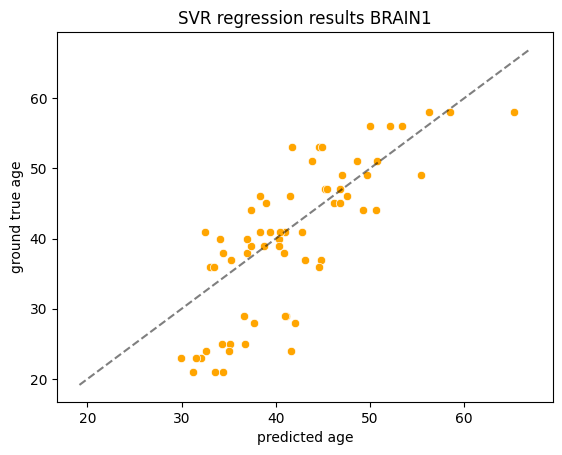

In [297]:


# n_features = 5
# n_features = -1

# sex = 'male'
print(data.shape[0])

n_features = n_opt_features[organ][sex]

X = data[data.columns[sorted_corr_ids[:n_features]]].values
y = data_header['Age'].loc[data_header['sex'] == sex].values

# print(X.shape)
print(f"{n_features=}")

cv = StratifiedKFold(n_splits=5)
# cv = LeaveOneOut()

preds = []
vals  = []
gls_preds = []

rmses = []
maes = []
r2s = []

for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
    X_train = X[train]
    y_train = y[train]
    X_test = X[val]
    y_test = y[val]

    # train_scaler = RobustScaler().fit(X_train)
    # test_scaler = RobustScaler().fit(X_test)
    # X_train = train_scaler.transform(X_train)
    # X_test = test_scaler.transform(X_test)

    X_train_ = X_train
    y_train_ = y_train
    
    X_val = X_test
    y_val = y_test
    
    model = svm.SVR(kernel='linear')
    # model = svm.LinearSVR(loss='squared_epsilon_insensitive')
    # model = LinearRegression()
    # model = Ridge()
    # model = XGBRegressor(n_estimators=300, max_depth=4, )
    # model = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
    #                      param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 20)})    
    
    model.fit(X_train_, y_train_)
    pred = model.predict(X_val)
    
    preds.append(pred)
    vals.append(y_val)

print("RMSE: ", RMSE(preds, vals))
# print("RMSE: ", RMSE(gls_preds, vals))
print("MAE: ", MAE(preds, vals))
print("R2: ", r2_score(vals, preds))

# model.coef_

colors = {
    'male': 'blue',
    "female": "orange"
}

g = sns.scatterplot(x=np.array(preds).ravel(), y=np.array(vals).ravel(), color=colors[sex])
g.set_title(f"SVR regression results {organ}")
g.set_xlabel("predicted age")
g.set_ylabel("ground true age")

lims = [
    np.min([g.get_xlim(), g.get_ylim()]),  # min of both axes
    np.max([g.get_xlim(), g.get_ylim()]),  # max of both axes
]


g.plot(lims, lims, '--', color='k', alpha=0.5)

# g.set_xlim(lims)
# g.set_ylim(lims)

transcripts[organ][sex] = data.columns[sorted_corr_ids[:n_features]].tolist()
model.coef_


In [302]:
transcripts_dict = (transcripts).copy()

In [305]:
from supervenn import supervenn
from upsetplot import plot, UpSet, from_contents

Chromosomes:  female
['BRAIN1'] : 
{'MSTRG.24372.1', 'ENST00000636170.1', 'MSTRG.29364.2', 'MSTRG.27407.13', 'MSTRG.30797.34', 'ENST00000368732.5', 'ENST00000414562.1', 'ENST00000562938.6'}
['BRAIN0'] : 
{'MSTRG.25577.29', 'MSTRG.8555.10', 'ENST00000514888.5', 'MSTRG.31819.2', 'ENST00000614366.1', 'MSTRG.16469.1', 'MSTRG.1517.15'}
['HEART'] : 
{'ENST00000466186.2', 'ENST00000519878.1', 'ENST00000679970.1', 'MSTRG.29296.55', 'ENST00000420515.1', 'MSTRG.11225.100', 'ENST00000554243.1', 'ENST00000524627.5', 'ENST00000366529.4', 'ENST00000556476.1', 'ENST00000372841.8'}


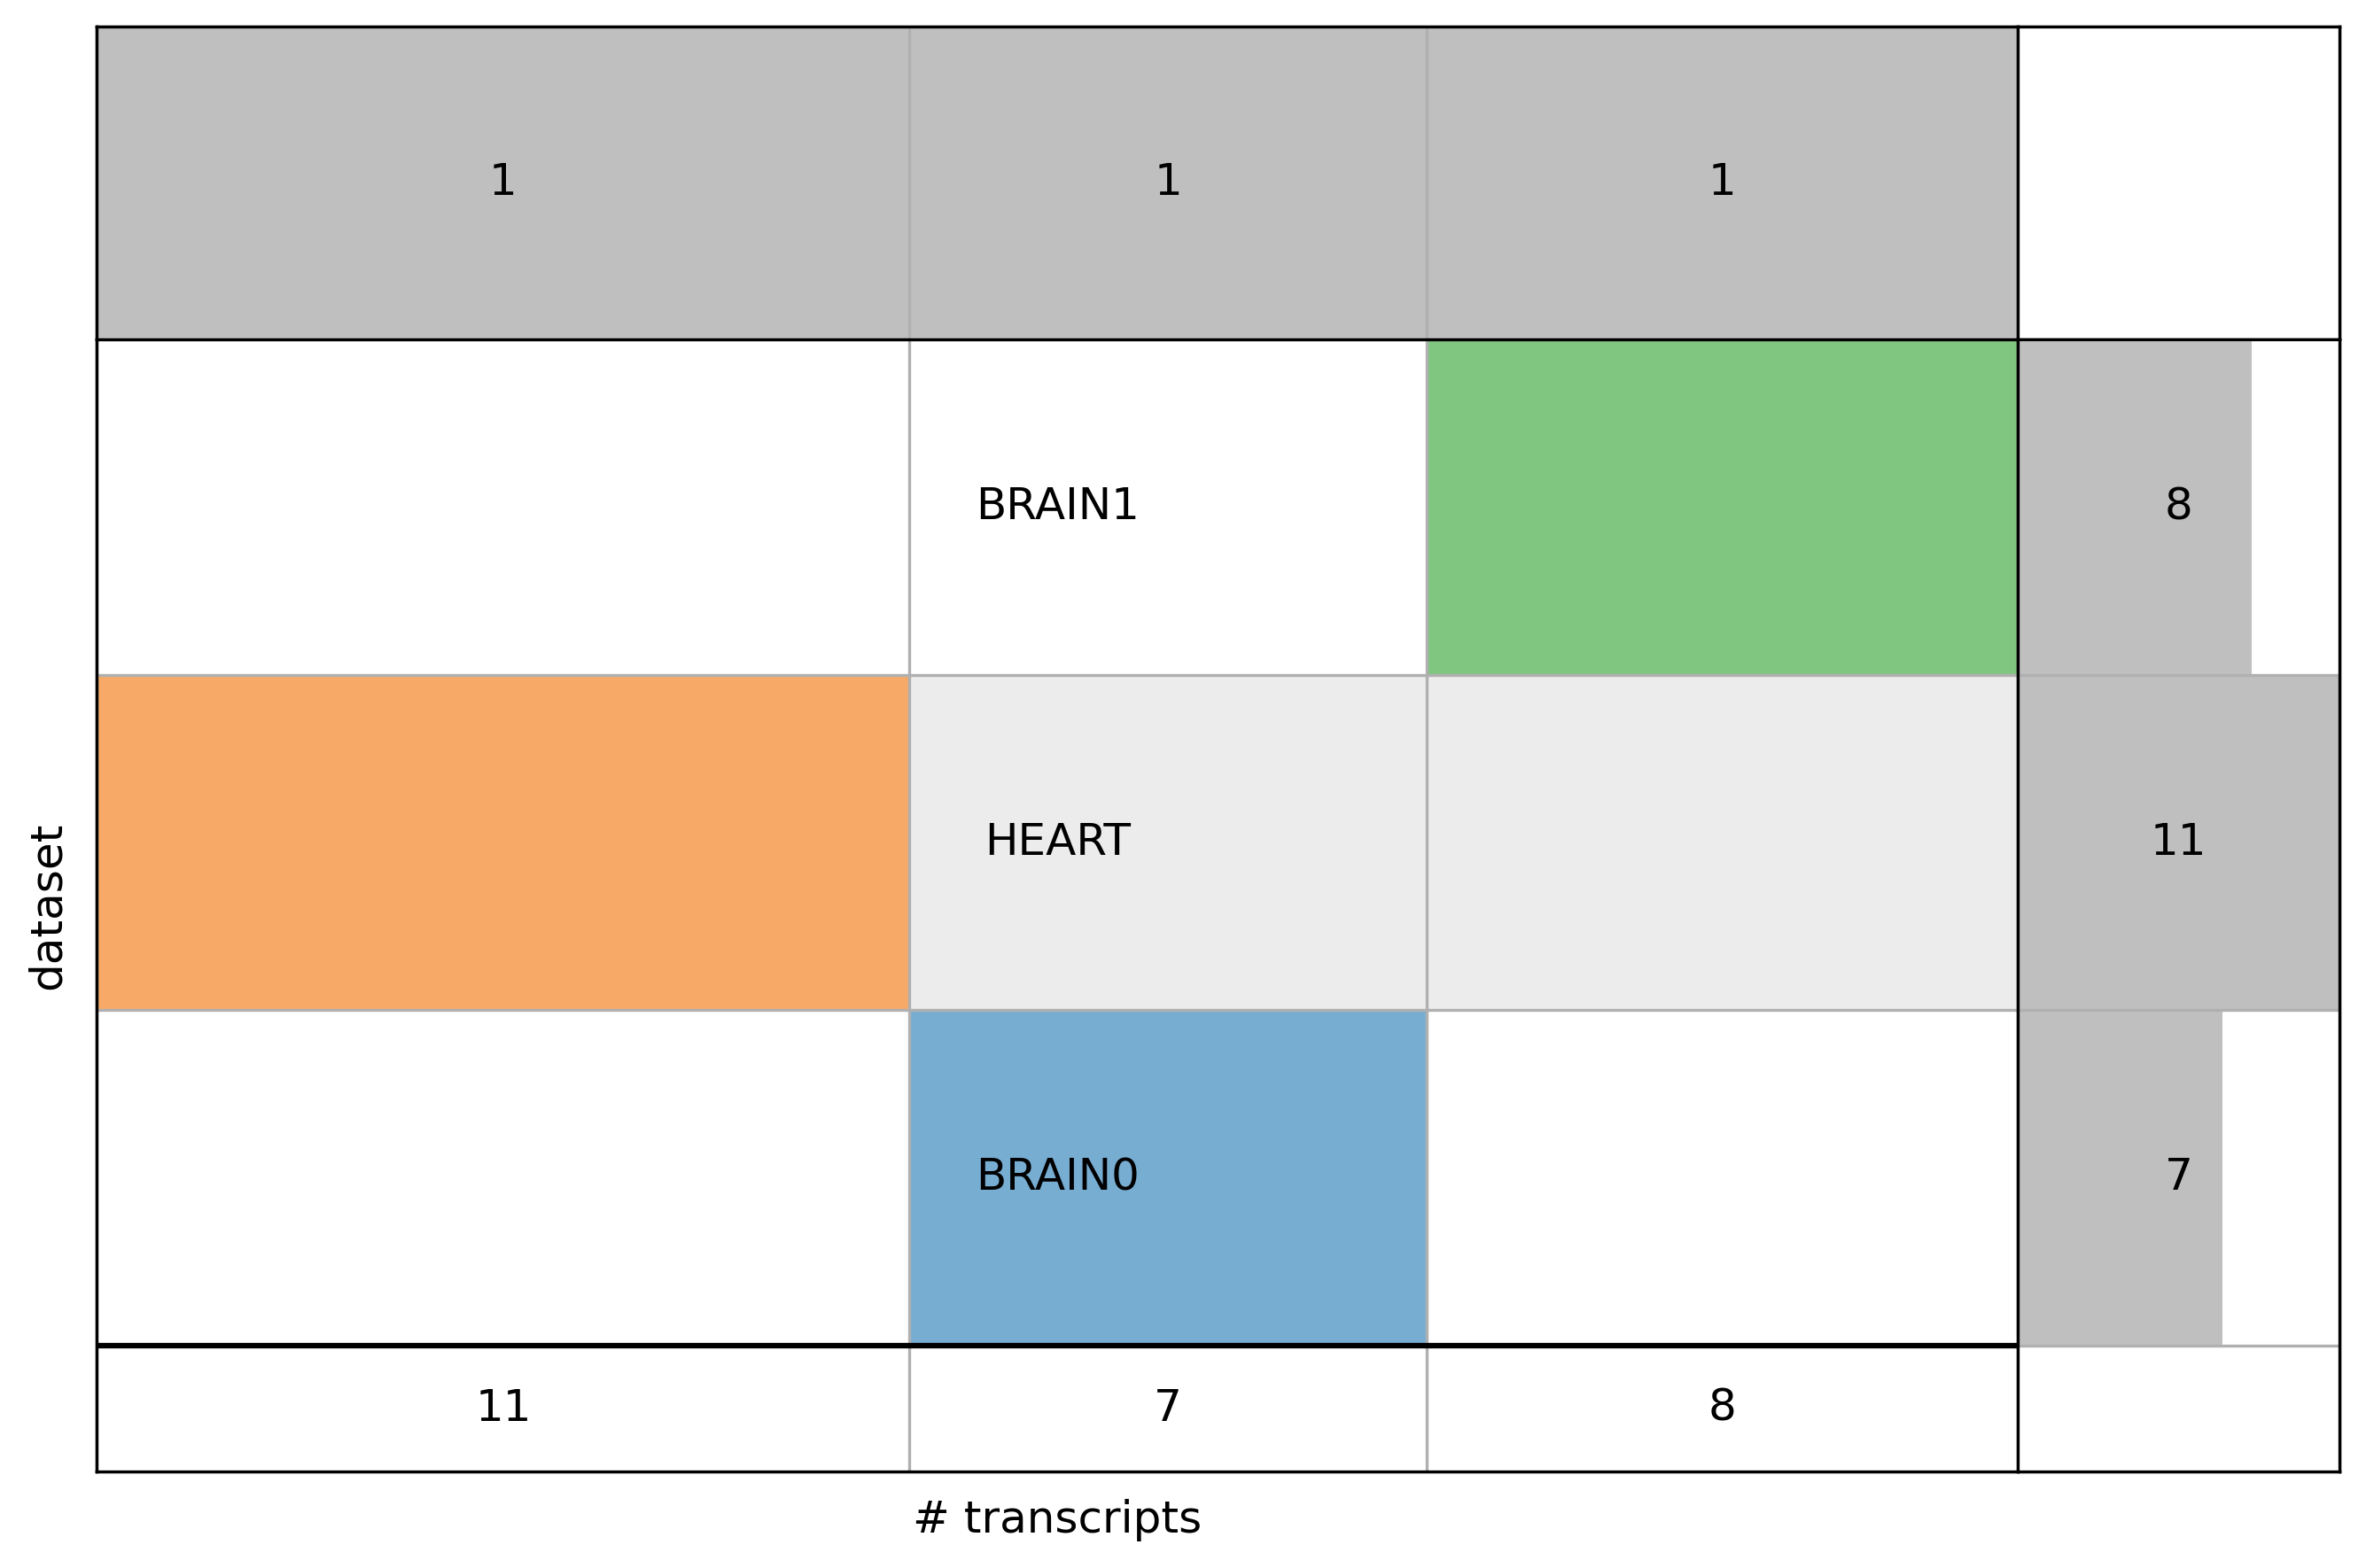

In [307]:

sex = ['male', 'female'][1]
test_dict = {}
for organ in ['BRAIN0', "HEART", "BRAIN1"]:
    test_dict[organ] = set(transcripts_dict[organ][sex])

# UpSet(from_contents(test_dict), show_counts=True).plot()

plt.figure(figsize=(9, 6), dpi=300)
g = supervenn(list(test_dict.values()), list(test_dict.keys()),
        # sets_ordering="minimize gaps",
        chunks_ordering='minimize gaps',
        )
plt.title(sex)
plt.tight_layout()
g.axes['main'].set_xlabel('# transcripts')
g.axes['main'].set_ylabel('dataset')


print("Chromosomes: ", sex)
for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)], ": ")
    print(g.chunks[el])
    # print(adata.var['gene_name'][list(g.chunks[el])])


Organ:  HEART
['male'] : 
{'ENST00000687101.1', 'ENST00000417040.1', 'ENST00000565500.5', 'ENST00000590632.1', 'ENST00000580063.1', 'MSTRG.23364.2', 'ENST00000473301.1', 'ENST00000511757.1', 'MSTRG.27522.8'}
['female'] : 
{'ENST00000466186.2', 'ENST00000519878.1', 'ENST00000679970.1', 'MSTRG.29296.55', 'ENST00000420515.1', 'MSTRG.11225.100', 'ENST00000554243.1', 'ENST00000524627.5', 'ENST00000366529.4', 'ENST00000556476.1', 'ENST00000372841.8'}


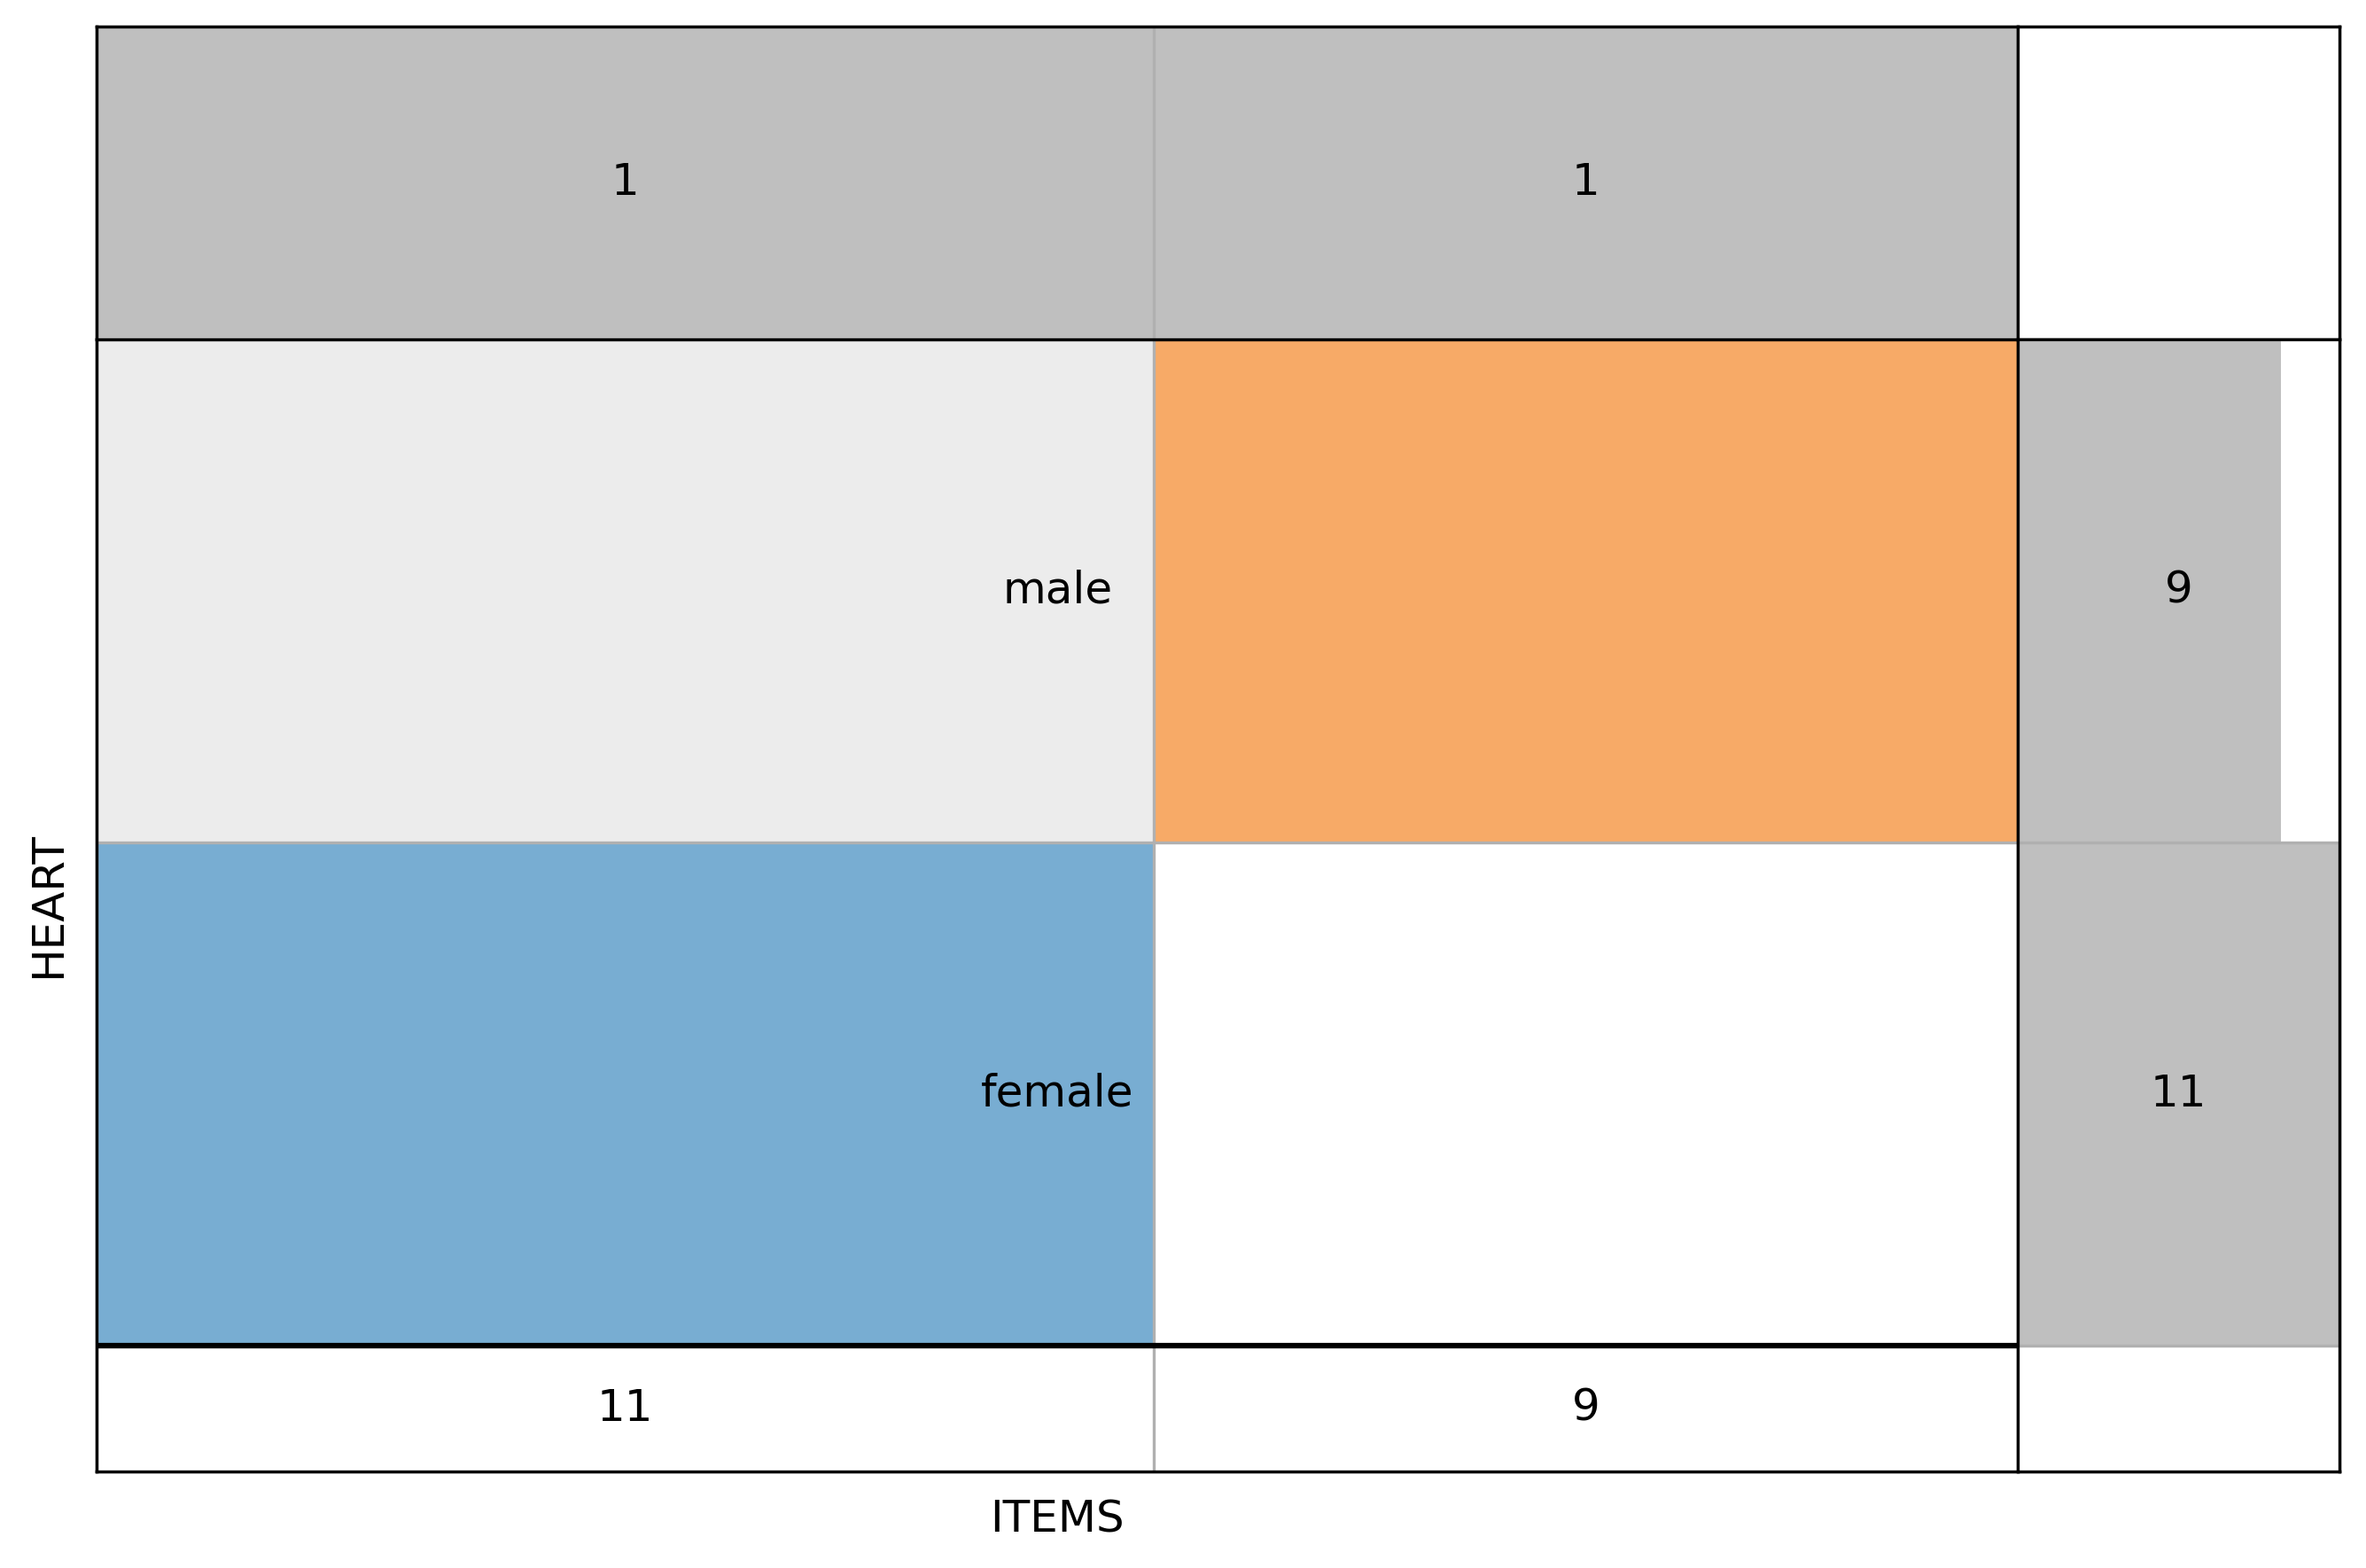

In [317]:
organ = ['BRAIN0', "HEART", "BRAIN1"][1]
test_dict = {}
for sex in ['male', 'female']:
    test_dict[sex] = set(transcripts_dict[organ][sex])

# UpSet(from_contents(test_dict), show_counts=True).plot()

plt.figure(figsize=(9, 6), dpi=300)
g = supervenn(list(test_dict.values()), list(test_dict.keys()),
        sets_ordering="minimize gaps",
        chunks_ordering='minimize gaps')
plt.title(sex)
plt.tight_layout()

g.axes['main'].set_ylabel(organ)

print("Organ: ", organ)
for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)], ": ")
    print(g.chunks[el])


<Axes: >

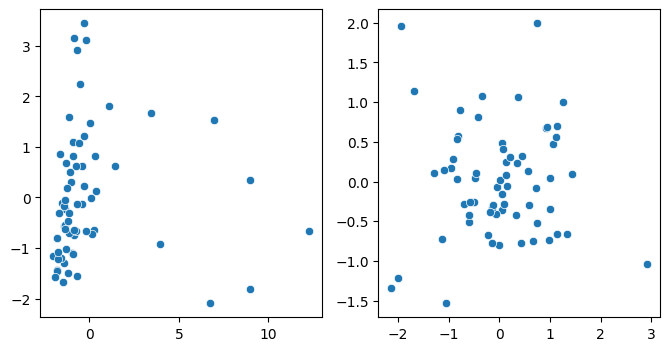

In [299]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

reducer = PCA(n_components=4)

X_transformed = reducer.fit_transform(RobustScaler().fit_transform(X))

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], ax=axs[0])
sns.scatterplot(x=X_transformed[:, 2], y=X_transformed[:, 3], ax=axs[1])
# sns.scatterplot(x=X[:, 2], y=X[:, 3], ax=axs[1])
